In [44]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset:

In [45]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.03, features_degree=2, seed=42, device='cpu', test_return=True)

In [46]:
data_gen.noise_delta

array({'mse_loss': {'mean': 1.6765352094745506e-05, 'std': 4.8766860786122565e-06}, 'l1_loss': {'mean': 0.0012438556947494456, 'std': 0.0003260375428975506}},
      dtype=object)

[[16.         12.          6.9         1.03        0.03926991  0.44      ]
 [19.         20.          7.56        1.47        4.75165889  0.05      ]
 [10.         16.          7.89        1.32        5.37997742  0.45      ]
 ...
 [18.         12.          6.93        0.88        1.80641578  0.19      ]
 [12.         17.          8.67        0.96        1.13882734  0.405     ]
 [21.         15.          6.99        1.23        2.94524311  0.345     ]]
[[0.00000000e+00 5.33333333e-01 2.66666667e-01 ... 3.95553973e-05
  5.59049616e-03 7.90123457e-01]
 [0.00000000e+00 7.33333333e-01 8.00000000e-01 ... 5.79130572e-01
  7.68693222e-02 1.02030405e-02]
 [0.00000000e+00 1.33333333e-01 5.33333333e-01 ... 7.42415253e-01
  7.83304746e-01 8.26446281e-01]
 ...
 [0.00000000e+00 6.66666667e-01 2.66666667e-01 ... 8.36992208e-02
  1.11047583e-01 1.47331905e-01]
 [0.00000000e+00 2.66666667e-01 6.00000000e-01 ... 3.32660892e-02
  1.49228130e-01 6.69421488e-01]
 [0.00000000e+00 8.66666667e-01 4.66666667e-

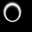

In [47]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray((imgs[0] * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [49]:
# load generator
generator = DGBaNConv17()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_mse_loss_0/DGBaNConv17_no_activation_function/DGBaNConv17_no_activation_function_57.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

DGBaNConv17(
  (linear_layers): NLinearNormAct(
    (linear_act): ModuleList(
      (0): LinearReparameterization()
      (1): ReLU()
      (2): LinearReparameterization()
      (3): ReLU()
      (4): LinearReparameterization()
      (5): ReLU()
      (6): LinearReparameterization()
      (7): ReLU()
      (8): LinearReparameterization()
      (9): ReLU()
    )
  )
  (conv_layers): BayesSequential(
    (bayes_modules): ModuleList(
      (0): BottleNeck(
        (block): ResidualAdd(
          (block): BayesSequential(
            (bayes_modules): ModuleList(
              (0-1): 2 x ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential(
                  (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (1): ReLU()
                )
              )
              (2): ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential

In [50]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))

print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))

4.3685993750462025e-05
0.00299268740373525
0.0005437762511379611


In [51]:
# setting the base feature
n_samples = 1000

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
pred_ring = pred_rings.mean(axis=0)

# summing the predictions
pred_prob = pred_ring * 255
true_prob = data_gen.ring_from_features(*features[0]) * 255

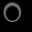

In [52]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

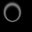

In [53]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

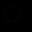

In [54]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [55]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

9.195466673775287e-05

(5, 9)


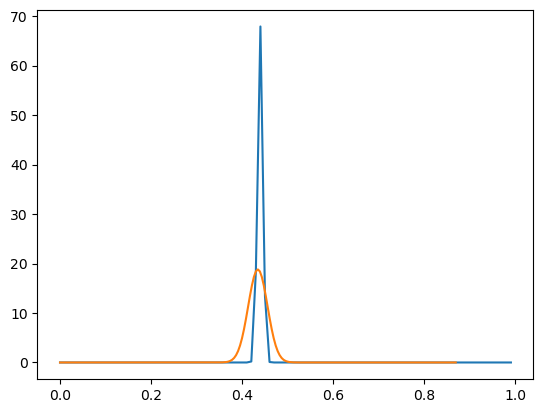

In [66]:
# getting the distribution for one pmt
pmt = (0, 0)
while true_prob[pmt] < 0.4 * 255:
    pmt = (np.random.randint(32), np.random.randint(32))
print(pmt)

hist_width = 0.01

pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)

plt.plot(np.arange(0, 1, hist_width), pred_noise)

val = np.arange(0, 2.01, hist_width) * true_prob[pmt] / 255
true_pmt_distr = np.exp(-(val - true_prob[pmt] / 255)**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * hist_width * true_prob[pmt] / 255
plt.plot(val, true_pmt_distr)
plt.show()